# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Data Preprocessing

In [2]:
df = pd.read_csv("./cleaned_data.csv")  

# Convert DateReported to datetime, sort by date, and set as index
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df = df.sort_values("DateReported")
df.set_index("DateReported", inplace=True)

df.head(5)


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_2573/1070397913.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)


,RecordID,Offense,IncidentID,BlockNumber,StreetName,Agency,HourReported,ReportingOfficer,InSession,DayOfWeek,TimeOfDay_Adjusted,TimeOfDay
DateReported,,,,,,,,,,,,
2019-10-05 04:48:36+00:00,25111,Animal Complaint,201900028849,NaN,JEFFERSON PARK AVE @ CLEVELAND AVE,CPD,48,"Bise, Collin",1,Saturday,Dusk,Night
2019-10-05 05:13:53+00:00,25110,Animal Complaint,201900028854,NaN,1ST ST S / LANKFORD AVE,CPD,113,"Reed, Patrick",1,Saturday,Dusk,Night
2019-10-05 05:36:03+00:00,25109,Larceny,201900028857,400.0,E MAIN ST,CPD,136,"Babij, Joshua",1,Saturday,Dusk,Night
2019-10-05 06:18:28+00:00,25108,Larceny,201900028865,1500.0,UNIVERSITY AVE,CPD,218,"Bise, Collin",1,Saturday,Dusk,Night
2019-10-05 11:48:08+00:00,25107,Stolen Property Offenses,201900028882,1100.0,AVON ST,CPD,748,"HARPINE, MATTHEW",1,Saturday,Sunrise,Night


## Aggregate daily crime counts

<Axes: xlabel='DateReported'>

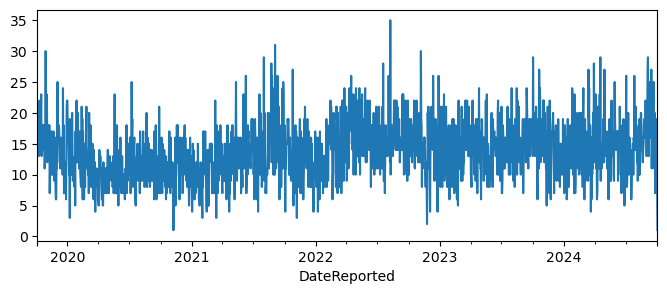

In [3]:

daily_crime_counts = df.resample("D").size()
daily_crime_counts.plot(figsize=(8, 3))

<Axes: ylabel='Count'>

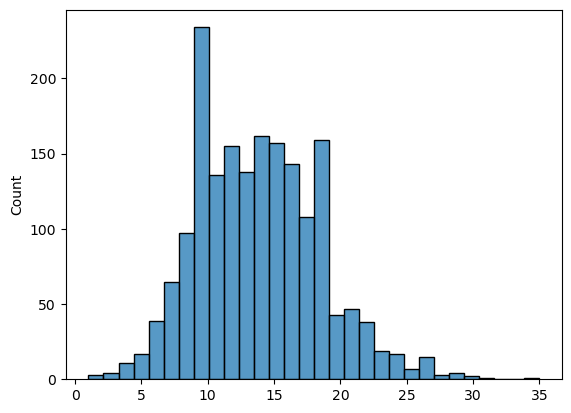

In [45]:
# View distribution of daily crime counts 
sns.histplot(daily_crime_counts)

# Check for Stationarity

In [41]:
adf_test = adfuller(daily_crime_counts)
print(f"ADF Statistic: {adf_test[0]}.")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print("The data is not stationary. Differencing may be needed.")
else:
    print("The data is stationary. No differencing needed.")

ADF Statistic: -5.370645108654265.
p-value: 3.902773357106362e-06
The data is stationary. No differencing needed.


# ACF / PACF Plots 

Text(0.5, 1.0, 'Autocorrelation (ACF) Plot')

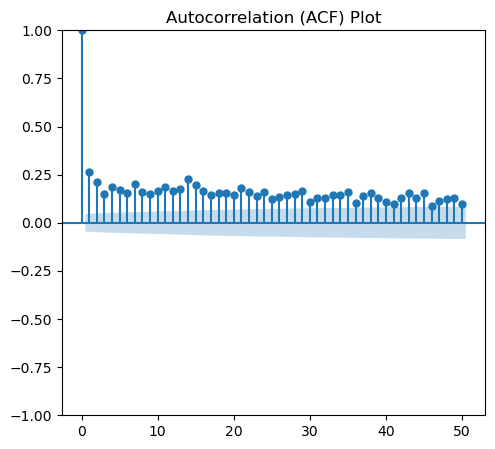

In [30]:
plt.figure(figsize=(12,5))

# ACF Plot
plt.subplot(1,2,1)
plot_acf(daily_crime_counts, lags=50, ax=plt.gca())  # Adjust lags as needed
plt.title("Autocorrelation (ACF) Plot")

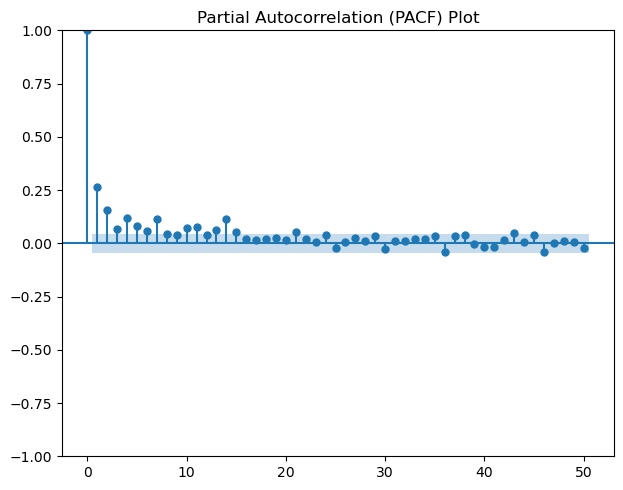

In [31]:
# PACF Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
plot_pacf(daily_crime_counts, lags=50, ax=plt.gca(), method="ywm")
plt.title("Partial Autocorrelation (PACF) Plot")

plt.tight_layout()
plt.show()

# Apply Differencing and Refit Model

Has stationarity (p<0.05 for Dicky-Fuller test), so we will apply differeincing using d=1. 

In [32]:
daily_crime_counts_diff = daily_crime_counts.diff().dropna()

Text(0.5, 1.0, 'Autocorrelation (ACF) Plot with Differencing')

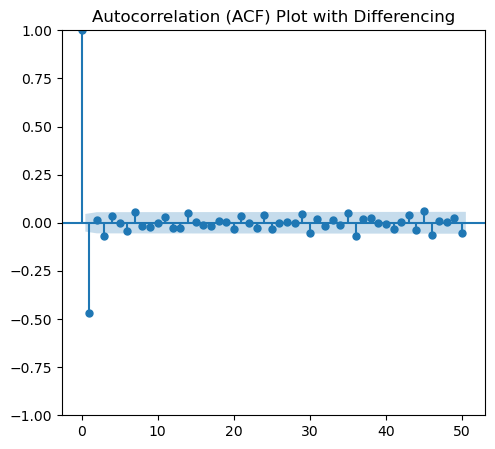

In [33]:
plt.figure(figsize=(12,5))

# ACF Plot
plt.subplot(1,2,1)
plot_acf(daily_crime_counts_diff, lags=50, ax=plt.gca())  # Adjust lags as needed
plt.title("Autocorrelation (ACF) Plot with Differencing")

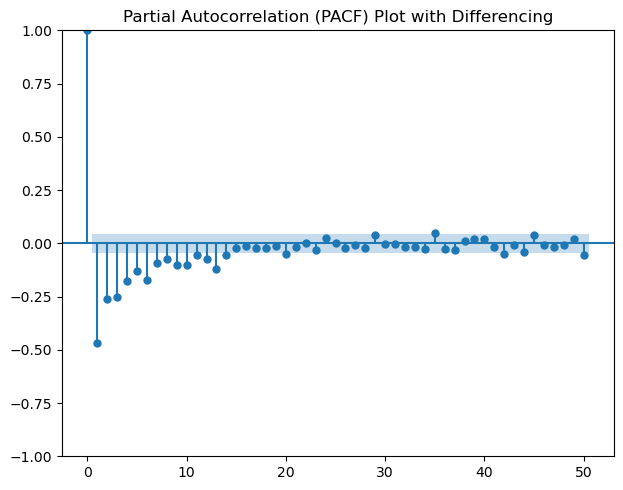

In [34]:
# PACF Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
plot_pacf(daily_crime_counts_diff, lags=50, ax=plt.gca(), method="ywm")
plt.title("Partial Autocorrelation (PACF) Plot with Differencing")

plt.tight_layout()
plt.show()

# Split Data into Training / Testing Sets

In [ ]:
train_size = int(len(daily_crime_counts_diff) * 0.8)
train, test = daily_crime_counts_diff[:train_size], daily_crime_counts_diff[train_size:]

# Fit SARIMA Model

## Different m values
m indicates seasonality. 
* m = 4 --> quarterly seasonality 
* m = 7 --> weekly seasonality 
* m = 12 --> monthly seasonality 


### m = 7 (weekly seasonality)

In [42]:
# Dermine optimal SARIMA parameters

# stepwise = True balances accuracy with speed and computational efficiency 
auto_model_m7 = auto_arima(daily_crime_counts, seasonal=True, m=7, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11490.817, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11042.049, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10512.150, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11488.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10510.915, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=10512.038, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=10496.758, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10496.264, Time=0.41 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=10488.755, Time=1.15 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=10488.584, Time=2.86 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=i

In [44]:
model_m7 = SARIMAX(daily_crime_counts, 
                 order=(2,1,1), 
                 seasonal_order=(2, 0, 1, 7), 
                 trend = "c")

results_m7 = model_m7.fit(maxiter = 10000) # Use disp=False to hide optimization output

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90212D+00    |proj g|=  2.99219D-01


 This problem is unconstrained.



At iterate    5    f=  2.87345D+00    |proj g|=  4.01070D-02

At iterate   10    f=  2.86945D+00    |proj g|=  9.80660D-03

At iterate   15    f=  2.86944D+00    |proj g|=  6.67243D-03

At iterate   20    f=  2.86929D+00    |proj g|=  3.45079D-02

At iterate   25    f=  2.86892D+00    |proj g|=  4.35484D-02

At iterate   30    f=  2.86869D+00    |proj g|=  7.91547D-03

At iterate   35    f=  2.86867D+00    |proj g|=  8.09688D-04

At iterate   40    f=  2.86866D+00    |proj g|=  2.04257D-03

At iterate   45    f=  2.86866D+00    |proj g|=  2.83736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     66   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [46]:
results_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1825
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -5235.311
Date:                           Sun, 16 Mar 2025   AIC                          10486.623
Time:                                   17:33:42   BIC                          10530.693
Sample:                               10-05-2019   HQIC                         10502.880
                                    - 10-02-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.32e-05      0.001      0.040      0.968      -0.002       0.002
ar.L1          0.1125      0.024      4.637      0.000       0.065       0.160
ar.L2          0.0508      0.023      2.205      0.027       0.006       0.096
ma.L1         -0.9693      0.006   -152.040      0.000      -0.982      -0.957
ar.S.L7        0.7107      0.147      4.832      0.000       0.422       0.999
ar.S.L14       0.0332      0.029      1.129      0.259      -0.024       0.091
ma.S.L7       -0.6684      0.144     -4.652      0.000      -0.950      -0.387
sigma2        18.1965      0.553     32.899      0.000      17.112      19.281
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                68.63
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Make Predictions

<Axes: >

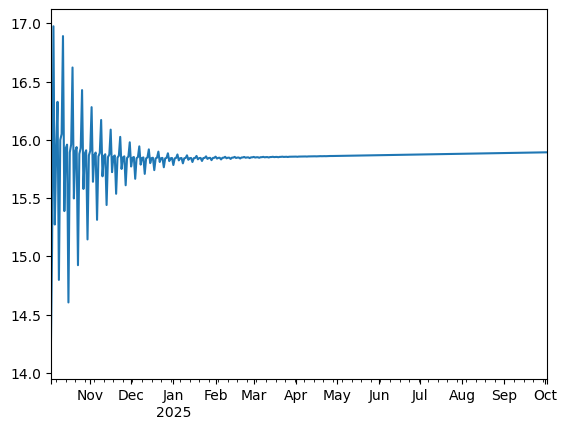

In [47]:
forecast = results_m7.get_forecast(steps=365)  # Forecasts next year (365 days)
forecast_mean = forecast.predicted_mean

forecast_mean.plot()

# Next Steps 

Fix model. 
* Try different values of m (seasonality periods)
* Improve model accuracy (tweak parameters, fix max iterations error)

## m = 7 

In [14]:
model = SARIMAX(daily_crime_counts_diff, order=(1,1,1), seasonal_order=(0,1,1,7))
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26411D+00    |proj g|=  1.05124D-01


 This problem is unconstrained.



At iterate    5    f=  3.02846D+00    |proj g|=  1.87735D-02

At iterate   10    f=  3.00982D+00    |proj g|=  2.78349D-03

At iterate   15    f=  3.00877D+00    |proj g|=  1.65499D-03

At iterate   20    f=  3.00868D+00    |proj g|=  5.88698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   5.887D-05   3.009D+00
  F =   3.0086752376790464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 

In [17]:
print(results.aic, results.bic)
print(results.summary())

10983.647267053162 11005.664833289808
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1824
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5487.824
Date:                           Tue, 18 Mar 2025   AIC                          10983.647
Time:                                   11:14:10   BIC                          11005.665
Sample:                               10-06-2019   HQIC                         10991.771
                                    - 10-02-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4741      0.019    -24.491      0.000      -0.512      -0.436
ma.L1

<Axes: >

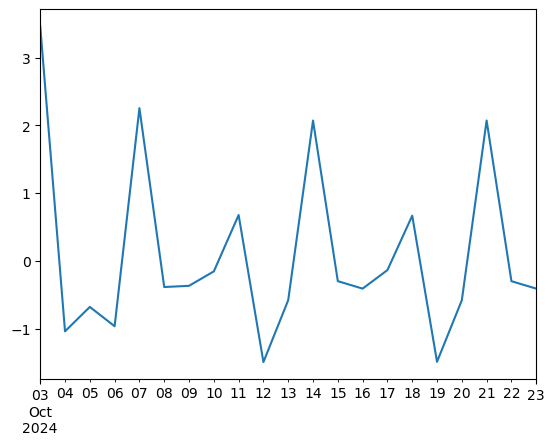

In [21]:
forecast = results.get_forecast(steps=21)  # Forecast for next 5 years (1825 days)
forecast_mean = forecast.predicted_mean

forecast_mean.plot()

## m = 12
Using parameters found through auto_arima

In [27]:
model = SARIMAX(daily_crime_counts_diff, order=(2,1,1), seasonal_order=(2,0,1,12))
results = model.fit(trace=False)
results.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: trace. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12223D+00    |proj g|=  1.82630D-01

At iterate    5    f=  3.02303D+00    |proj g|=  7.21093D-02

At iterate   10    f=  3.00537D+00    |proj g|=  4.21103D-02

At iterate   15    f=  2.99319D+00    |proj g|=  1.78981D-02

At iterate   20    f=  2.99051D+00    |proj g|=  4.67379D-03

At iterate   25    f=  2.98998D+00    |proj g|=  1.38197D-03

At iterate   30    f=  2.98991D+00    |proj g|=  1.03865D-03

At iterate   35    f=  2.98990D+00    |proj g|=  1.15050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1824
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -5453.578
Date:                            Tue, 18 Mar 2025   AIC                          10921.156
Time:                                    11:23:44   BIC                          10959.714
Sample:                                10-06-2019   HQIC                         10935.380
                                     - 10-02-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5895      0.022    -26.720      0.000      -0.633      -0.546
ar.L2         -0.2604      0.023    -11.253      0.000      -0.306      -0.215
ma.L1         -0.9999      0.299     -3.346      0.001      -1.586      -0.414
ar.S.L12      -0.8793      0.156     -5.637      0.000      -1.185      -0.574
ar.S.L24       0.0009      0.027      0.033      0.973      -0.052       0.054
ma.S.L12       0.8572      0.155      5.533      0.000       0.554       1.161
sigma2        23.1084      6.898      3.350      0.001       9.588      36.629
===================================================================================
Ljung-Box (L1) (Q):                   8.08   Jarque-Bera (JB):                27.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

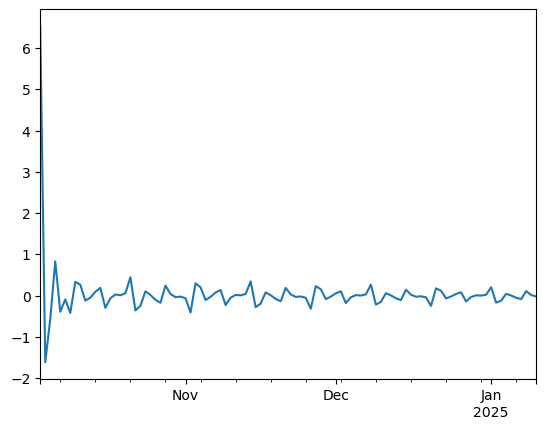

In [29]:
forecast = results.get_forecast(steps=100)  
forecast_mean = forecast.predicted_mean

forecast_mean.plot()

# Try Aggregating Data by Month

In [ ]:
monthly_crime_counts = df.resample("D").size()
monthly_crime_counts.plot(figsize=(8, 3))

# Ideas 
1. Aggregate crime counts by weeks, then months, the maybe years 
2. Aggregate counts by In-Session rather than days 